# 3 | Deep Learning with PyTorch



## Tensors

A **tensor** is the fundamental building block of all DL toolkits.
Despite the fancy name, a tensor is just a multi-dimensional array.
A single number, or scalar, is like a point and is a zero-dimensional tensor.
A vector is like a line segment and is a one-dimensional tensor.
A matrix is like a surface and is a two-dimensional tensor.
A cuboid is like an object and is a three-dimensional tensor.
The same applies to collections of numbers of higher dimensions that are still called "tensors".

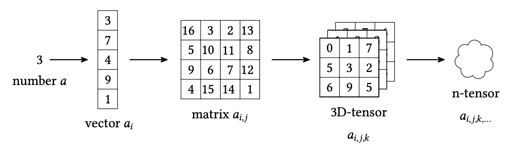

In DL, tensors are just a multi-dimensional arrays and only partially related to those in _tensor calculus_ or _tensor algebra_.
In mathematics, a tensor is a mapping between vector spaces which sometime is represented as a multi-dimensional array.

### The Creation of Tensors
Knowing the basic operations on tensors is the best way to become familiar with them.
The most basic operation is to create tensors.
There are several ways to create tensors.
Code readability and performance are the criteria often used to choose one.

NumPy is a library to handle multi-dimensional arrays in a generic way.
Multi-dimensional arrays in NumPy are like tensors even though they are not called so.
Tensors are used very widely in scientific computations as generic storage for data.
A color image is an example of 3D tensor with width, height, and color plane as dimensions.

Besides dimensions, tensors are characterized by the type of its elements.
PyTorch supports 13 types of elements: float16, float32, float64, bfloat16, complex32, complex64, complex128, integer8, integer16, integer32, integer64, uinteger8, and boolean.
There are also 4 composite types for "quantised numbers" using the types above, just with different bit representation and interpretation.

Each tensor type is implemented by a class.
See the documentation to discover all of them.
The most common types are `torch.FloatTensor` (corresponding to a 32-bit float), `torch.ByteTensor` (an 8-bit unsigned integer), and `torch.LongTensor` (a 64-bit signed integer).

The 3 ways to create a tensor in PyTorch are:

- by calling the constructor of the required type, such as `torch.FloatTensor(3, 2)`,
- by asking PyTorch to create a tensor with specific data, such as zeros using the function `torch.zeros(3, 2)`,
- by converting a NumPy array or a Python iterable into a tensor, like with `torch.tensor(np.zeros(shape=(3, 2)))`.


In [4]:
import numpy as np
import torch as th

a = th.FloatTensor(3, 2)
a

tensor([[0., 0.],
        [0., 0.],
        [0., 0.]])

The script import PyTorch and NumPy, then creates a new float tensor of size 3×2.
PyTorch now initialises memory with zeros, a different behaviour from previous versions.
Originally it just allocated memory and kapt it uninitialised: faster but less safe.
This behaviour might change again in the future so it is good practice to always initialise tensors:

In [5]:
th.zeros(3, 4)

tensor([[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]])

Alternatively call the tensor modification method:

In [6]:
th.zero_(a)

tensor([[0., 0.],
        [0., 0.],
        [0., 0.]])

Notice that there are two types of operation for tensors: **inplace** and **functional**.
Inplace operations have an underscore appended to their name, operate on the tensor's content, and eventually return the modified tensor itself.
The functional equivalent creates a copy of the tensor's content, applies the operation and returns the copy leaving the original tensor untouched.
Inplace operations are usually faster but less safe (the same tensor shared in different places where changes are not expected).

Alternatively use the tensor constructor passing a Python iterable (i.e.: a list or tuple) to it:

In [7]:
th.FloatTensor([[1, 2, 3], [3, 2, 1]])

tensor([[1., 2., 3.],
        [3., 2., 1.]])

or by passing a NumPy array to it:

In [8]:
n = np.zeros(shape=(3, 2))
b = th.tensor(n)
n, b


(array([[0., 0.],
        [0., 0.],
        [0., 0.]]),
 tensor([[0., 0.],
         [0., 0.],
         [0., 0.]], dtype=torch.float64))

`torch.tensor(...)` accepts the NumPy array and creates a tensor of appropriate shape from it.
In the example above, NumPy has implicitly created a double array (64-bit float).
The resulting tensor uses `torch.float64` as the `dtype` property shows.
In DL, double precision is usually not required, uses extra memory and causes performance overhead.
Using the 32-bit or even the 16-bit floats is common practice.
Specify explicitly the type of the NumPy array to do so:

In [9]:
n = np.zeros(shape=(3, 2), dtype=np.float16)
b = th.tensor(n)
n, b

(array([[0., 0.],
        [0., 0.],
        [0., 0.]], dtype=float16),
 tensor([[0., 0.],
         [0., 0.],
         [0., 0.]], dtype=torch.float16))

Alternatively, specify the desired type with the `dtype` parameter of the `torch.tensor(...) function:


In [10]:
n = np.zeros(shape=(3, 2))
b = th.tensor(n, dtype=th.float16)
n, b

(array([[0., 0.],
        [0., 0.],
        [0., 0.]]),
 tensor([[0., 0.],
         [0., 0.],
         [0., 0.]], dtype=torch.float16))

Notice that `torch.tensor()` and explicit PyTorch type specification were added in the 0.4.0 release.
Before it, the `torch.from_numpy()` was the recommended way which had however its limitations.
Nowadays `torch.from_numpy()` is still present for backward compatibility, but it is deprecated in favor of `torch.tensor()`.


### Scalar Tensor

PyTorch supports zero-dimensional tensors (scalars) since the 0.4.0 release.
Such tensors can be the results of some operations like sum or mean on other tensors.
Previously, they were handled as one-dimensional tensor (vector) of size equals one.

This solution worked, but wasn't convenient: extra indexation was needed to access the value.
Now zero-dimensional tensors are natively supported by `torch.tensor()` and scalar is accessed with `.item()`:

In [11]:
vec = th.tensor([1, 2, 3])
sum = vec.sum()
val = sum.item()
sca = th.tensor(1)

vec, sum, val, sca

(tensor([1, 2, 3]), tensor(6), 6, tensor(1))

### Tensor Operations

Way too many operations can be performed on tensors, and won't be all covered here.
Refer to PyTorch documentation at [http://pytorch.org/docs/](http://pytorch.org/docs/) for more details.
The `torch` package contains functions that usually accept tensors as argument.
The `tensor` class has methods that operates on the tensor itself.

Several tensor operations in PyTorch correspond to their NumPy counterpart.
Examples are `torch.stack()`, `torch.transpose()`, and `torch.cat()`.

### GPU Tensors

PyTorch transparently supports CUDA GPUs.
All tensor operations have two versions, CPU and GPU, selected automatically on the tensor type.

GPU tensors are defined in the `torch.cuda` package instead of just `torch`.
For example, `torch.FloatTensor` is a CPU 32-bit float tensor while `torch.cuda.FloatTensor` is its GPU counterpart.

> PyTorch has a notion of backend which abstract specific devices.
> PyTorch supports not just CPU and CUDA, but also Apple hardware with Metal Performance Shaders (MPS) (`mps` package).

The method `to(device)` creates a copy of the tensor to the specified device (CPU or GPU).
If the tensor is already on the desired device, nothing happens and the original tensor is returned.
The device type can be specified with a string: "cpu" or "cuda".
If multiple devices of a type are available, a zero-based index is needed as in "cuda:1",

The device type can also be specified by an instance of `torch.device`.
This class accepts the device name and optional index.

In [12]:
a = th.FloatTensor([2, 3])
mps_a = a.to('mps')

a, mps_a

(tensor([2., 3.]), tensor([2., 3.], device='mps:0'))

In [13]:
a + 1, mps_a - 1, mps_a.device

(tensor([3., 4.]),
 tensor([1., 2.], device='mps:0'),
 device(type='mps', index=0))

> Before the 0.4.0 release, copying between CPU and GPU was performed by tensor methods `.cpu()` and `.gpu()`.
> In newer PyTorch versions, you can create a desired `torch.device` and use it with `.to(device)` where needed.
> All methods are still available and we can choose the most convenient to use.

## Gradients

The killer feature of PyTorch is not the transparent GPU support, but rather the automatic computation of gradients.
This functionality was originally implemented in the Caffe toolkit, standard in any DL libraries.

Computing gradients manually is extremely painful to implement and debug even for simple neural network (NN).
Involves calculating derivatives for all functions, appling the chain rule, and implementing the result.
Useful once to understand the basics of DL, but not to repeat in every experiment to run.

Luckily, gradients are now carefully calculated, backpropagated, and applied to the network by PyTorch for you.
All you need to do is to define network architectures using DL primitives.

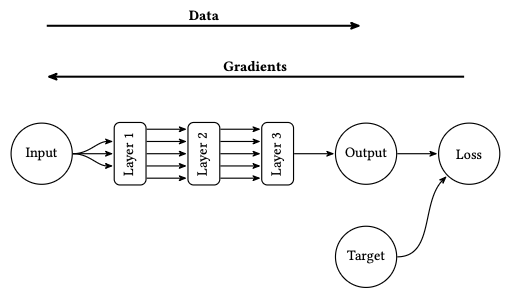

There are two fundamentally different ways to compute gradients:

- **Static graph:** calculations are defined in advance and can't be modified later.
  The NN graph is processed and optimised by the DL library ahead of execution.
  TensorFlow (versions before 2.0), Theano, and other DL toolkits use this approach.
- **Dynamic graph:** the NN graph is not defined in advance, but the transformations on actual data.
  The DL library memorises the operations order and unroll them to accumulate the network parameters' gradients when needed.
  This approach is called _notebook gradients_ and is implemented by PyTorch, Chainer, and others toolkits.

Toolkits based on static graphs move computations on GPU minimising data transfer overhead and are typically faster.
They usually optimise computations more substantially, altering the order or removing parts of the graph.
Solutions based on dynamic graphs are computationally more expensive but give the developer much more freedom.
(I.e.: for this data apply this network twice, for that data use a different network with gradients clipped by the batch mean.)

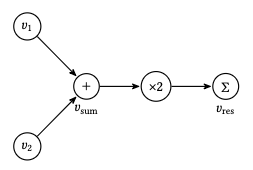

For example, we can specify if a tensor requires gradients to be computed when creating it.
Then, we add them element-wise (which is vector `[3, 3]`), double every element, and sum them together resulting in `12`:

In [14]:
v1 = th.tensor([1.0, 1.0], requires_grad=True)
v2 = th.tensor([2.0, 2.0])

v_sum = v1 + v2

v_res = (2 * v_sum).sum()

v1, v2, v_sum, v_res

(tensor([1., 1.], requires_grad=True),
 tensor([2., 2.]),
 tensor([3., 3.], grad_fn=<AddBackward0>),
 tensor(12., grad_fn=<SumBackward0>))

By checking the attributes of these tensors, we notice that `v1` and `v2` are the only leaf nodes.
We notice also that they all require the gradient to be calculates with the only exception of `v2`:

In [15]:
v1.is_leaf, v2.is_leaf, v_sum.is_leaf, v_res.is_leaf

(True, True, False, False)

In [16]:
v1.requires_grad, v2.requires_grad, v_sum.requires_grad, v_res.requires_grad

(True, False, True, True)

The property `.requires_grad` is "sticky": it is set in one of variables have it set.
This is logical since gradiets are normally computed for all the intermediate steps.
Notice however that computation doesn't mean gradients will be preserved in the `.grad` field.

For memory efficiency, gradients are stored only for leaf nodes with `requires_grad=True`.
To retain gradients of non-leaf nodes, call their `retain_grad()` method.

Call `backward()` to calculate the gradients and `.grad` to access the result:

In [17]:
v_res.backward()

v1.grad

tensor([2., 2.])

PyTorch computes the numerical derivative of `v_res` when `backward()` is called.
The call invokes `backward()` on all the variables referenced by `v_res`.
The value `2` of the `v1` gradient means that increasing any element in `v1` by `1`, `v_res` grows by `2`.

Remember that PyTorch calculates gradients only for leaf tensors with `requires_grad=True`.
If we try to check the gradients of `v2`, we get nothing:

In [18]:
v2.grad

This guarantees efficient computation and memory usage despite the size of the network (millions of parameter, hundreds of layers).
In gradient descent optimisation, we care on the final results not in the intermediate gradients.
In the model, we only want to adjust the  gradients of loss with respect to model parameters (weights).
If you want the gradient of input data, just mark the tensor with `requires_grad=True` on creation.
This is useful for instance to generate adversarial example to fool existing NN of djust pretrained word embeddings.

This is all you need to implement your own NN optimiser.
The following section will cover extra convenient functions, classes and algorithms.
Remember you can reimplement all of them using the building block seen so far.
PyTorch is so popular for its elegance and flexibility.

> Before the release of PyTorch 0.4.0, gradients accumulation was done in the `Variable` class.
> This class was very thin as it was wrapping the tensor, automatically saving the computation history for backpropagation.
> This class is available in `torch.autograd` in current releases, but deprecated and about to disappear.
> The current implementation is much more intuitive and robust, and should be preferred.


## NN Building Blocks

The `torch.nn` package contains many predefined classes providing common building blocks.
They are built to be convenient to use: they handle mini-batches, use sensible defaults, and initialise weights properly.
All modules are _callable_, so an instance can be used like a function.
For example, the `Linear` class implements a feed-forward layer with an optional bias:

In [19]:
from torch import nn

l = nn.Linear(2, 5)
v = th.FloatTensor([1, 2])
l(v)

tensor([-1.0405,  0.2138,  0.1998, -0.6290, -1.4227], grad_fn=<ViewBackward0>)

Here, we created a randomly initialized feed-forward layer, with two inputs and five outputs, and applied it to our float tensor.
All classes in the `torch.nn` packages inherit from the `nn.Module` base class, which you can use to implement your own higher-level NN blocks.
You will see how you can do this in the next section, but, for now, let's look at useful methods that all `nn.Module` children provide.
They are as follows:

The example randomly initialises a feed‑forward layer with two inputs and five outputs, then applies it to a given float tensor.
All classes in `torch.nn` inherit from the `nn.Module` base class, which you can extend to build higher‑level blocks.
For now, here are most useful methods common to all `nn.Module` subclasses:

- `parameters()`: returns an iterator on all variables that require gradient computation (module weights),
- `zero_grad()`: initializes all gradients of all parameters to zero,
- `to(device)`: moves all module parameters to a given device (CPU or GPU),
- `state_dict()`: returns the dictionary with all module parameters (useful for model serialization),
- `load_state_dict()`: initializes the module with the state dictionary.

The whole list of available classes can be found in the documentation at [http://pytorch.org/docs](http://pytorch.org/docs).

A class that is worth a special mention is `Sequential` that is used to combine layers into pipes.
The following example defines a three-layer NN with softmax on output, applied along dimension 1 (dimension 0 is batch samples), **rectified linear unit (ReLU)** nonlinearities, and dropout.
Then we create a tensor that we push through the network as a mini-batch of one vector.


In [21]:
s = nn.Sequential(
    nn.Linear(2, 5),
    nn.ReLU(),
    nn.Linear(5, 20),
    nn.ReLU(),
    nn.Linear(20, 10),
    nn.Dropout(p=0.3),
    nn.Softmax(dim=1))
s

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): ReLU()
  (2): Linear(in_features=5, out_features=20, bias=True)
  (3): ReLU()
  (4): Linear(in_features=20, out_features=10, bias=True)
  (5): Dropout(p=0.3, inplace=False)
  (6): Softmax(dim=1)
)

In [27]:
b = th.FloatTensor([[1, 2]])
b, s(b)


(tensor([[1., 2.]]),
 tensor([[0.2007, 0.1412, 0.1195, 0.0500, 0.0937, 0.0800, 0.0629, 0.0635, 0.1331,
          0.0555]], grad_fn=<SoftmaxBackward0>))

## Custom Layers

As said before, `nn.Module` is the base class for PyTorch's neural network layers.
It's more than a common parent: by subclassing `nn.Module`, you can create your own blocks that stack neatly, can be reused, and integrate seamlessly with PyTorch.

At its core, `nn.Module` offers rich, practical features:

- **Submodule tracking**: assign submodules to fields and PyTorch registers them automatically (e.g., two feed-forward `Linear` layers inside your block).
- **Parameter management**: list parameters (`parameters()`), zero gradients (`zero_grad()`), move to CPU/GPU (`to(device)`), serialize/deserialize (`state_dict()`, `load_state_dict()`), and run a function across submodules (`apply()`).
- **Data flow convention**: define the transformation in `forward()` by overriding it.
- **Advanced hooks**: register hooks to modify computations or gradient flow, mainly for advanced use.

These features let us nest submodels into larger models in a consistent way, which helps manage complexity.
Whether it's a single linear layer or a 1001‑layer **residual NN (ResNet)**, anything that follows `nn.Module` conventions can be used the same way.
This improves code reusability and keeps irrelevant implementation details hidden.

PyTorch's design makes implementing custom modules easy.
In practice, all you need to do is registering your submodules and implementing the `forward()` method.

Let's make the previous `Sequential` example more generic and reusable by creating a module class that inherits from `nn.Module`.
(See `Chapter03/01_modules.py` for the full example.)


In [29]:
class OurModule(nn.Module):

    def __init__(self, num_inputs, num_classes, dropout_prob=0.3):
        super(OurModule, self).__init__()

        self.pipe = nn.Sequential(
            nn.Linear(num_inputs, 5),
            nn.ReLU(),
            nn.Linear(5, 20),
            nn.ReLU(),
            nn.Linear(20, num_classes),
            nn.Dropout(p=dropout_prob),
            nn.Softmax(dim=1))

    def forward(self, x):
        return self.pipe(x)

In the constructor, we pass three arguments: input size, output size, and an optional dropout probability.
First, call the parent constructor to initialise the base class.

Next, create an `nn.Sequential` with the required layers and assign it to a field (for example, pipe).
Assigning a `Sequential` to a field automatically registers it, since `Sequential` (like all classes in `torch.nn`) inherits from `nn.Module`.
You don't need to call anything; submodules are registered when assigned to fields.
If you need to add layers programmatically, you can use `add_module()`.

Finally, override `forward()` with your data transformation.
Our module is a simple wrapper around `Sequential`, so we just ask `self.pipe` to transform the data.
Apply modules by calling the instance itself, not by calling `forward()` directly.
`nn.Module` overrides `__call__()`, which handles framework logic before invoking your `forward()`.
Calling `forward()` yourself bypasses this and can lead to incorrect results.

That's all we need to define our module.
Now, let's use it.
We instantiate our module with the required input and output sizes, create a tensor, and call the module to transform it.
We then print the model to show its structure (via `__str__()`/`__repr__()`), and finally display the transformation result.

In [31]:
if __name__ == "__main__":
    net = OurModule(num_inputs=2, num_classes=3)
    print(net)

    v = th.FloatTensor([[2, 3]])
    out = net(v)
    print(out)

    print("MPS's availability is %s" % th.mps.is_available())
    if th.mps.is_available():
        print("* Data from MPS: %s" % out.to('mps'))

OurModule(
  (pipe): Sequential(
    (0): Linear(in_features=2, out_features=5, bias=True)
    (1): ReLU()
    (2): Linear(in_features=5, out_features=20, bias=True)
    (3): ReLU()
    (4): Linear(in_features=20, out_features=3, bias=True)
    (5): Dropout(p=0.3, inplace=False)
    (6): Softmax(dim=1)
  )
)
tensor([[0.3726, 0.4186, 0.2088]], grad_fn=<SoftmaxBackward0>)
MPS's availability is True
* Data from MPS: tensor([[0.3726, 0.4186, 0.2088]], device='mps:0', grad_fn=<ToCopyBackward0>)


PyTorch remains fully dynamic.
The `forward()` method runs on every batch, so you can implement data‑dependent logic such as hierarchical softmax or randomly selecting a subnetwork.
Your module can also accept multiple arguments and many optional parameters.


## Loss Functions and Optimizers

We cover now two core parts of PyTorch that simplify training: loss functions and optimisers.

A network that maps inputs to outputs isn't enough for training.
We also need a learning objective: a function that takes the model's output and the target, and returns a single number indicating how close the prediction is.
This is the loss function, and its output is the loss value.
We use this loss to compute parameter gradients and update them to reduce the loss, improving the model over time.
Because loss functions and gradient‑based updates are so common and varied, PyTorch provides many built‑in options.

### Loss Functions

Loss functions live in the `nn` package as subclasses of `nn.Module`.
They typically take two inputs: the model's prediction and the target (ground truth or label).
PyTorch provides many built‑in losses, and you can define your own.

Common choices include:
- `nn.MSELoss`: mean squared error; standard for regression.
- `nn.BCELoss` and `nn.BCEWithLogitsLoss`: binary cross‑entropy.
  The former expects a probability (often after a `Sigmoid`); the latter takes raw scores and applies `Sigmoid` internally, which is usually more stable and efficient.
- `nn.CrossEntropyLoss` and `nn.NLLLoss`: multi‑class classification.
  `CrossEntropy` takes raw class scores and applies `LogSoftmax` internally; `NLLLoss` expects log probabilities.

### Optimizers

An optimiser updates model parameters using their gradients to reduce the loss, nudging the model towards better predictions.
Though the idea is simple, the details matter, and optimisation remains an active research area.

PyTorch's `torch.optim` includes many popular choices, such as:

- `SGD`: stochastic gradient descent, with optional momentum
- `RMSprop`: an adaptive method from Geoffrey Hinton
- `Adagrad`: adaptive gradients
- `Adam`: a widely used blend of `RMSprop` and `Adagrad` ideas

All optimisers share a common interface, so you can swap them easily and compare convergence and results.
When creating one, pass an iterable of parameters to update—typically `model.parameters()` from your top‑level `nn.Module`.

The typical training loop is as follows:

```python:
1  for batch_x, batch_y in iterate_batches(data, batch_size=N):
2      batch_x_t = torch.tensor(batch_x)
3      batch_y_t = torch.tensor(batch_y)
4      out_t = net(batch_x_t)
5      loss_t = loss_function(out_t, batch_y_t).
6      loss_t.backward()
7      optimizer.step()
8      optimizer.zero_grad()
```

Training typically loops over the dataset multiple times; one full pass is an epoch.
Because datasets rarely fit in memory, we split them into equal‑sized batches.
Each batch contains input samples and target labels, both as tensors (line 2 and 3).

For each batch, pass the inputs through the network (line 4), then feed the outputs and labels to the loss function (line 5).
The loss is a single tensor value measuring how far the predictions are from the targets.
The network's computations and the loss form a graph of tensor operations.

Autograd tracks this graph.
To compute gradients for all parameters, call `backward()` on the loss (line 6).
Gradients accumulate in each parameter's `grad` field, even if a tensor is used multiple times (as with a **recurrent neural network (RNN)** cell).

After `loss.backward()` finishes, call the optimiser's `step()` (line 7) to update parameters using their gradients.
You must also clear old gradients with `zero_grad()` (line 8).
You can call it on the model or the optimiser, and it's fine to place it at either the start or end of the loop.

This setup is flexible and supports advanced use cases, such as using two optimisers on different models in the same training (common in **generative adversarial networks (GANs)**).

## Monitoring with TensorBoard

Training neural networks from scratch is often painful and uncertain. 
Outside polished tutorials, many choices can go wrong—even with modern toolkits that set sensible defaults for weight initialisation and optimiser settings. 
Expect your first runs to fail.

With experience, you'll learn typical failure modes, but you still need visibility into what's happening during training.
Even small models can have complex, nonlinear dynamics, so monitoring is essential.

Common items to track include:
- **Loss**: overall loss and its components (e.g., base loss, regularisation) over time.
- **Validation results**: on training and test sets.
- **Gradients and weights**: summary statistics.
- **Model outputs**: e.g., class‑probability entropy for classification, raw predictions for regression.
- **Hyperparameters**: learning rates and others if they change over time.

You may also track domain‑specific metrics (e.g., embedding projections, audio or images from GANs) and training speed (e.g., epoch duration) to spot bottlenecks.

In short, we need a tool to log many time‑varying values and visualise them for analysis, ideally built for deep learning. 

### TensorBoard 101

When the first edition of this book was written, options for NN monitoring were limited.
As ML and DL have grown, more tools have emerged, such as MLflow ([https://mlflow.org/](https://mlflow.org/)).
In this book, we focus on TensorBoard, though you may wish to try alternatives.

TensorFlow has included TensorBoard since its early releases.
It lets you observe and analyse neural network metrics during and after training.
TensorBoard is a powerful, general tool with a large community, and it looks good too.

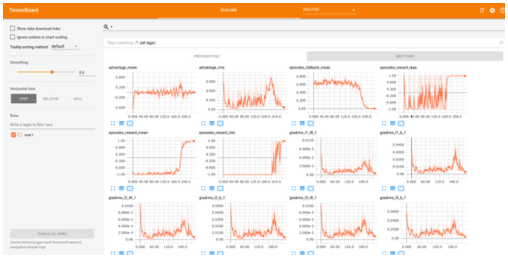

Architecturally, TensorBoard is a Python web service. 
You start it locally and point it to the directory where your training writes logs. 
Then open your browser on its port (typically 6006) to see an interactive UI that updates in real time.
It is also handy when training on a remote machine.

TensorBoard began inside TensorFlow but is now a separate, Google‑maintained project with its own package. 
It still uses TensorFlow's log format, so PyTorch must write logs in that format.
PyTorch includes built‑in support via `torch.utils.tensorboard`, so no third‑party libraries are needed.

### Plotting Metrics

To show how easy TensorBoard is to use, here's a simple example that just logs values (see `Chapter03/02_tensorboard.py` for the full code).

In the code, we import the necessary packages, create a log writer, and define the functions we'll visualise.

By default, `SummaryWriter` creates a unique subdirectory under `runs` for each run so you can compare trainings.
The name includes the date/time and host.
To override it, set `log_dir`.
To add a suffix, use the `comment` argument (e.g., `dropout=0.3` or `strong_regularisation`).

Next, we iterate over angle ranges in degrees, convert them to radians, and compute the function values.
We log each value with `add_scalar(name, value, step)`, where `step` is an integer iteration counter.


In [4]:
import math
from torch.utils.tensorboard.writer import SummaryWriter

FUNCTIONS = {
    "sin": math.sin,
    "cos": math.cos,
    "tan": math.tan,
}

if __name__ == '__main__':
    with SummaryWriter() as writer:
        for angle in range(-360, 360):
            angle_rad = angle * math.pi / 180
            for name, fun in FUNCTIONS.items():
                val = fun(angle_rad)
                writer.add_scalar(name, val, angle)


After the loop, close the writer. 
It flushes periodically (every two minutes by default), so you'll see values even during long runs.
If you need an explicit flush, call `flush()`.

Running this code prints nothing to the console, but creates a new subdirectory under `runs` with a single file.
To view the results, start TensorBoard.

```sh:
> tensorboard --logdir runs

TensorFlow installation not found - running with reduced feature set.
Serving TensorBoard on localhost; to expose to the network, use a proxy or pass --bind_all
TensorBoard 2.15.1 at http://localhost:6006/ (Press CTRL+C to quit)
```

If you're running TensorBoard on a remote server, start it with the `–bind_all` option so it's accessible from other machines.
Then open [http://localhost:6006](http://localhost:6006) in your browser to view the dashboard.

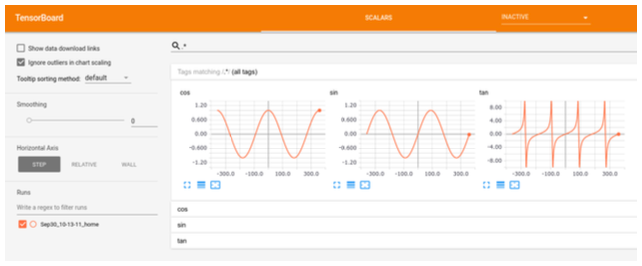

The graphs are interactive: hover to see exact values, drag to zoom, and double‑click to zoom out.
If you run your programme multiple times, each run appears in the **Runs** list on the left.
You can toggle them to compare optimisation dynamics.
TensorBoard can visualise scalars, images, audio, text, embeddings, and even your network's structure.
See the documentation for details.

Now let's see a real neural network optimisation problem in PyTorch.

## GAN on Atari Images

Almost every DL book uses MNIST, which has become rather dull. 
To do something different, we'll illustrate PyTorch with **Generative Adversarial Networks (GANs)**.
We will train one to generate Atari game screenshots.

A basic GAN has two neural networks: a "cheater" (the _generator_) and a "detective" (the _discriminator_).
They compete: the generator creates fake samples that should look real, while the discriminator tries to spot them.
Over time, both improve: the generator makes more realistic images, and the discriminator becomes better at detection.

GANs are used for image enhancement, realistic image synthesis, and feature learning.
Our example isn't practically useful, but it neatly demonstrates the PyTorch concepts covered so far.

The full code is in `Chapter03/03_atari_gan.py`.
We'll show only the key parts, skipping imports and constants.

In [2]:
import cv2

import gymnasium as gym
import gymnasium.spaces as spaces

# dimension input image will be rescaled
IMAGE_SIZE = 64


class InputWrapper(gym.ObservationWrapper):
    """
    Preprocessing of input numpy array:
    1. resize image into predefined size
    2. move color channel axis to a first place
    """

    def __init__(self, *args):
        super(InputWrapper, self).__init__(*args)

        old_space = self.observation_space
        assert isinstance(old_space, spaces.Box)

        self.observation_space = spaces.Box(
            self.observation(old_space.low),
            self.observation(old_space.high),
            dtype=np.float32
        )

    def observation(self, observation: gym.core.ObsType) -> gym.core.ObsType:
        # resize image
        new_obs = cv2.resize(
            observation, (IMAGE_SIZE, IMAGE_SIZE))

        # transform (w, h, c) -> (c, w, h)
        new_obs = np.moveaxis(new_obs, 2, 0)
        return new_obs.astype(np.float32)

ModuleNotFoundError: No module named 'cv2'

## PyTorch Ignite

Lorem ipsum.

### Ignite Concepts

Lorem ipsum.

### GAN Training on Atari using Ignite

Lorem ipsum.